# 2. Characterising companies based on financial metrics - Factor Analysis
## Instructions
Previously, the author performed [principle component analysis](https://medium.com/@leehongkai/characterising-companies-based-on-financial-metrics-during-covid19-1a6ce9cc4ada) on the finanical metrics for all the S&P500 companies and found that the first 5 PCs carried most of the variance ratio.
Note that a pcincipal component (dimension) from PCA can be considered factor that consist of a space that made up of a set of features. Here, we dive deep at the first 5 PCs/factors and their respective underlying features.

## Packages
You'll need to you install the quanp package (https://quanp.readthedocs.io/en/latest/installation.html) that should install all necessary packages/libraries required to execute the codes in this tutorial. Please create and use virtualenv with python version 3.6 to avoid dependency problem.

### Install Packages

In [1]:
import sys
!conda install seaborn scikit-learn statsmodels numba pytables
!conda install -c conda-forge python-igraph leidenalg
!{sys.executable} -m pip install quanp
!{sys.executable} -m pip install factor_analyzer 

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quanp as qp

from IPython.display import display
from matplotlib import rcParams
%matplotlib inline

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### Download data

In [3]:
# S&P 500 metadata
df_metadata = qp.datasets.get_wiki_sp500_metadata()
# 
# S&P 500 fundamentals
df_fundamental = qp.datasets.download_tickers_fundamental()

### Loading data

In [3]:
# Optional: The data retried in cell above were saved as csv file You may activated this cell to avoid 
# rerunning the downloading cell above.
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)
print(df_fundamental.columns)

Index(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'beta',
       'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'symbol', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
     

In [4]:
ls_fundamental_target = ['beta','bookValuePerShare','currentRatio', 'dividendYield','epsChangePercentTTM','epsChangeYear',
 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'interestCoverage', 
 'ltDebtToEquity', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM', 
 'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
    'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
    'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
    'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
    'shortIntToFloat', 'totalDebtToCapital', 'totalDebtToEquity',
    'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']

df_fundamental_target = df_fundamental[ls_fundamental_target]

# Principle Component Analysis (PCA)

PCA, a form of orthogonal rotation so that the extracted components/factors are uncorrelated with each other, can reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data. Previously, we found that the 'elbow' point of the pca variance ratios seems to suggest at least up to PC5 will be useful to characterize the companies. 

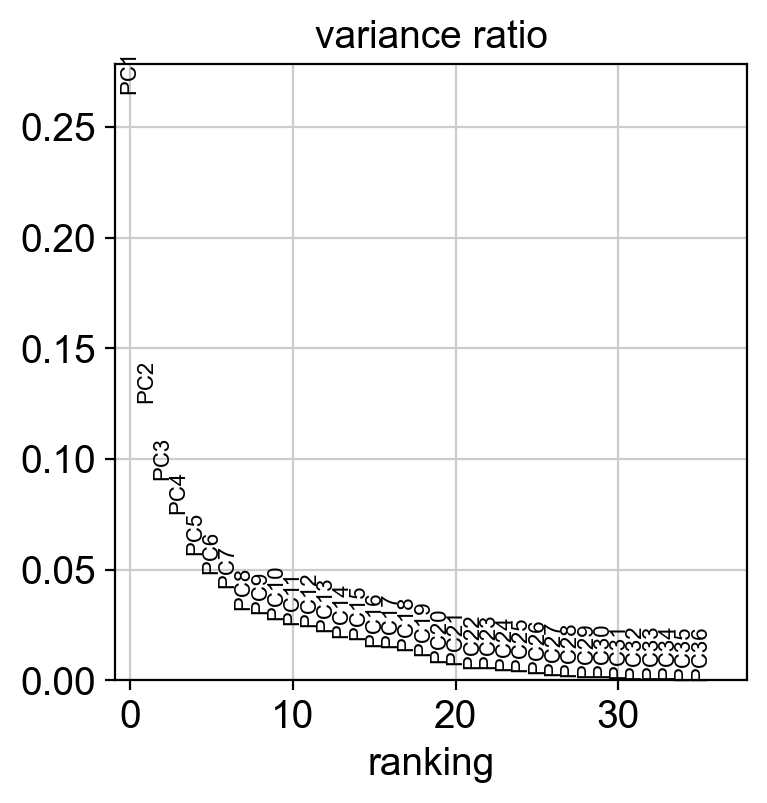

In [5]:
# Loading pandas dataframe as anndata 
adata = qp.AnnData(df_fundamental[ls_fundamental_target])

# # log(x+1) transformation for all data
qp.pp.log1p(adata)

# Standardization scaling per feature
qp.pp.scale(adata)

# pca & plotting variance ratio for each pc
qp.tl.pca(adata, svd_solver='auto')
qp.pl.pca_variance_ratio(adata, n_pcs=len(adata.var_names))

For instance, we also found that the Information Technology, Financial, and Energy can be separated from low to high PC1.

In [6]:
# add a new `.obs` column for all comapnanies called `GICS_Sector`
adata.obs['GICS_Sector'] = df_fundamental['GICS Sector']
adata

AnnData object with n_obs × n_vars = 505 × 37
    obs: 'GICS_Sector'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'GICS_Sector' as categorical


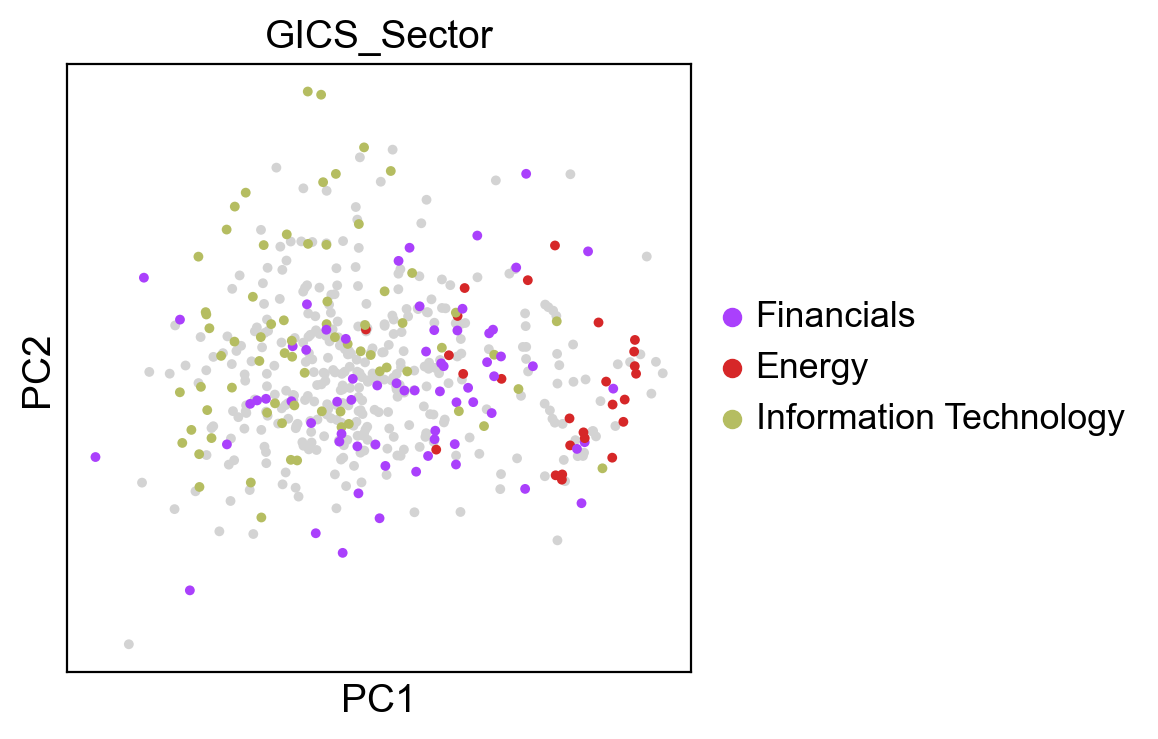

In [7]:
qp.pl.pca(adata, color=['GICS_Sector'], size=50, 
          groups=['Financials', 'Energy', 'Information Technology']);

# Dissecting PCA outputs
In fact, PCA or a similar analysis, Factor analysis (FA), fundamentally allow variables that are correlated with one another but largely independent of other subsets of variables to combine as components/factors. Both PCA and FA summarize patterns of correlations among observed variables and reduce a large number of observed variables (features/dimensions) to a smaller number of components/factors. Frequently, these factors/components analysis produces an operational definition for an underlying processes by using correlation/contributions (loadings) of observed variable in a factor/component (Tabachnick & Fidell, 2013).

In order to obtain the PCA eigenvectors (i.e. cosines of rotation of variables into components) and eigenvalues (i.e. the proportion of overall variance explained) to calculate the loading of each component (i.e. eigenvectors normalized to respective eigenvalues; loadings are the covariances between variables and components), we exported the data from the anndata to a pandas dataframe and re-performed the pca analysis using the ```sklearn.decomposition.PCA```.

In [8]:
# export to dataframe
df_fundamental_anndata = adata.to_df()

# remove columns/features that has zero value in all rows - they contributed no variance/information
df_fundamental_anndata = df_fundamental_anndata.loc[:, (df_fundamental_anndata != 0).any(axis=0)]


In [9]:
import seaborn as sns

plt.figure(figsize=(25,25))

# plot the heatmap for correlation matrix
corr = df_fundamental_anndata.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, 
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(220, 20, n=200),
                 mask=mask, square=True, 
                 annot=True, fmt='.2f')

NameError: name 'plt' is not defined

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
n=5
pca = PCA(n) 

# Transform log_samples using the PCA fit above
pca_values = pca.fit_transform(df_fundamental_anndata)

We can calculate loadings of PCA for each components using the following formula:-  
$Loadings = Eigenvectors.\sqrt{Eigenvalues}$


In [10]:
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
pca_loading_matrix = pd.DataFrame(pca_loadings, columns=['PC{}'.format(i) for i in range(1, n+1)], 
                              index=df_fundamental_anndata.columns)
pca_loading_matrix['Highest_loading'] = pca_loading_matrix.idxmax(axis=1)
pca_loading_matrix = pca_loading_matrix.sort_values('Highest_loading')
pca_loading_matrix

NameError: name 'pca' is not defined

In [11]:
import seaborn as sns

plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(pca_loading_matrix.drop('Highest_loading', axis=1).T, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(220, 20, n=200),
                square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

NameError: name 'plt' is not defined

From the heatmap above, we see some patterns of loadings explaining each PCs, but they are not too obvious. This is because the goal of PCA is to extract maximum variance from a dataset with a few orthogonal components, in order to provide only an empirical summary of the dataset. We proceed further for the Factor Analysis to see if the loadings can provide a clearer underlying patterns for each factor. 

# Factor analysis (FA)
In contrast to PCA, the goal of FA (if it is orthogonal rotation) is to reproduce the correlation matrix with a few orthogonal factors.

### Testings for Factorability of R 
A matrix that is 'factorable' should include severable sizable correlations. The expected size depends, to some extent, on N (larger sample sizes tend to produce smaller correlations), but if no correlation exceed 0.30, use of FA is questionable because there is probably nothing to factor-analysed. 

The Barlett test of Sphericity is a not-so-good sensitive test of the hypothesis that the correlation in a correlation matrix are zero - the test is likely to be significant with substantial/large sample size, even if the correlation are very low. Therefore, the test is recommended only if there are fewer than 5 samples per variable. In our case, we have 23 variables with 505 samples (companies) in total (we can only maximum of 115 samples to qualify for this test's recommended sample size) - we are not qualified for this test. However, we are just going to perform this to see if it is significant. The P-value is 0 (significant), although it is not a reliable "preferable conclusion".

In [175]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
print('Bartlett-sphericity Chi-square: {}'.format(calculate_bartlett_sphericity(df_fundamental_anndata)[0]))
print('Bartlett-sphericity P-value: {}'.format(calculate_bartlett_sphericity(df_fundamental_anndata)[1]))

Bartlett-sphericity Chi-square: 19371.021167577015
Bartlett-sphericity P-value: 0.0


Alternatively, Kaiser-Meyer-Olkin test (Kaiser's measure of sampling adequacy) is a ratio of the sum of squared correlations to the sum of squared correlations plus sum of squared partial correlation. The value approaches 1 if partial correlation are small. Values of 0.6 and above are recommended for a a good FA.

In [176]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_fundamental_anndata[df_fundamental_anndata.columns])
print('KMO score: {}'.format(kmo_model))

KMO score: 0.7570427456258492


/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


### Estimating number of factors and filtering for variables with communalities > 0.2
Here, as we are only interested to know how many significant factors we should use for the following work, we used a simple factor analysis without any rotation. In fact, we can just use the estimation based on the PCA variance ratio (eigenvalue) above.

In [177]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation=None)
fa.fit(df_fundamental_anndata)
ev, v = fa.get_eigenvalues()

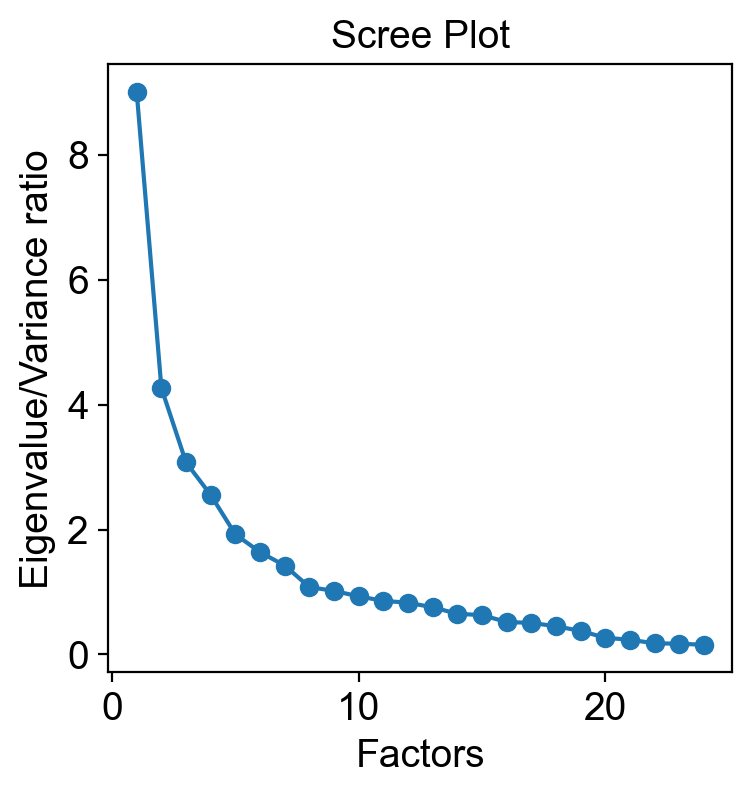

In [178]:
# create scree plot using matplotlib
plt.scatter(range(1, 25), ev[:24])
plt.plot(range(1,25), ev[:24])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue/Variance ratio')
plt.grid()
plt.show()

Again, we see that the elbow point on the screen plot fall at about F5. Next, the communalities of the variables/features are inspected to see if the variables are well defined by the solution. Communalities indicate the percent of variance in a variable that overlaps variance in the factors. Ideally, we should drop variables with low communalities, for example, exclude those variables with <0.2 communalities. Here, found only 23 of 34 variables had commualities >0.2. However, for the exploratory purpose of this dataset, we don't consider removing those variables.

In [179]:
communalities = pd.DataFrame(fa.get_communalities(), index=list(df_fundamental_anndata.columns))
features_comm = list(communalities[communalities[0] > 0.2].index)
print('Total variables/features with communalities >0.2: {}'.format(len(features_comm)))
    

Total variables/features with communalities >0.2: 22


### Factor analysis with Varimax (orthogonal) rotation and Maximum Likelihood factor extraction method

In [185]:
fa = FactorAnalyzer(rotation='varimax', n_factors=5, method='ml')
fa.fit(df_fundamental_anndata);

# # check eigenvalues
# ev, v = fa.get_eigenvalues()

In [186]:
fa_loading_matrix = pd.DataFrame(fa.loadings_, columns=['FA{}'.format(i) for i in range(1, 5+1)], 
                              index=df_fundamental_anndata.columns)
fa_loading_matrix['Highest_loading'] = fa_loading_matrix.idxmax(axis=1)
fa_loading_matrix = fa_loading_matrix.sort_values('Highest_loading')
fa_loading_matrix

,FA1,FA2,FA3,FA4,FA5,Highest_loading
operatingMarginTTM,0.923401,-0.063009,-0.030478,-0.190534,0.048005,FA1
pegRatio,0.287610,-0.176353,-0.046378,0.083627,-0.011275,FA1
prRatio,0.618357,-0.095416,-0.158789,0.000609,0.338723,FA1
operatingMarginMRQ,0.775357,-0.076454,-0.000661,-0.138443,0.119145,FA1
netProfitMarginTTM,0.946387,-0.064939,-0.047965,-0.064642,-0.016140,FA1
netProfitMarginMRQ,0.783330,-0.087634,-0.048407,-0.088717,0.023019,FA1
returnOnAssets,0.819399,-0.136698,-0.002457,0.545139,-0.069857,FA1
marketCap,0.398453,0.355496,0.010814,0.075126,0.006770,FA1
returnOnEquity,0.714095,-0.094188,0.334207,0.252565,-0.173604,FA1
interestCoverage,0.280611,-0.130502,0.052387,0.228682,-0.037354,FA1


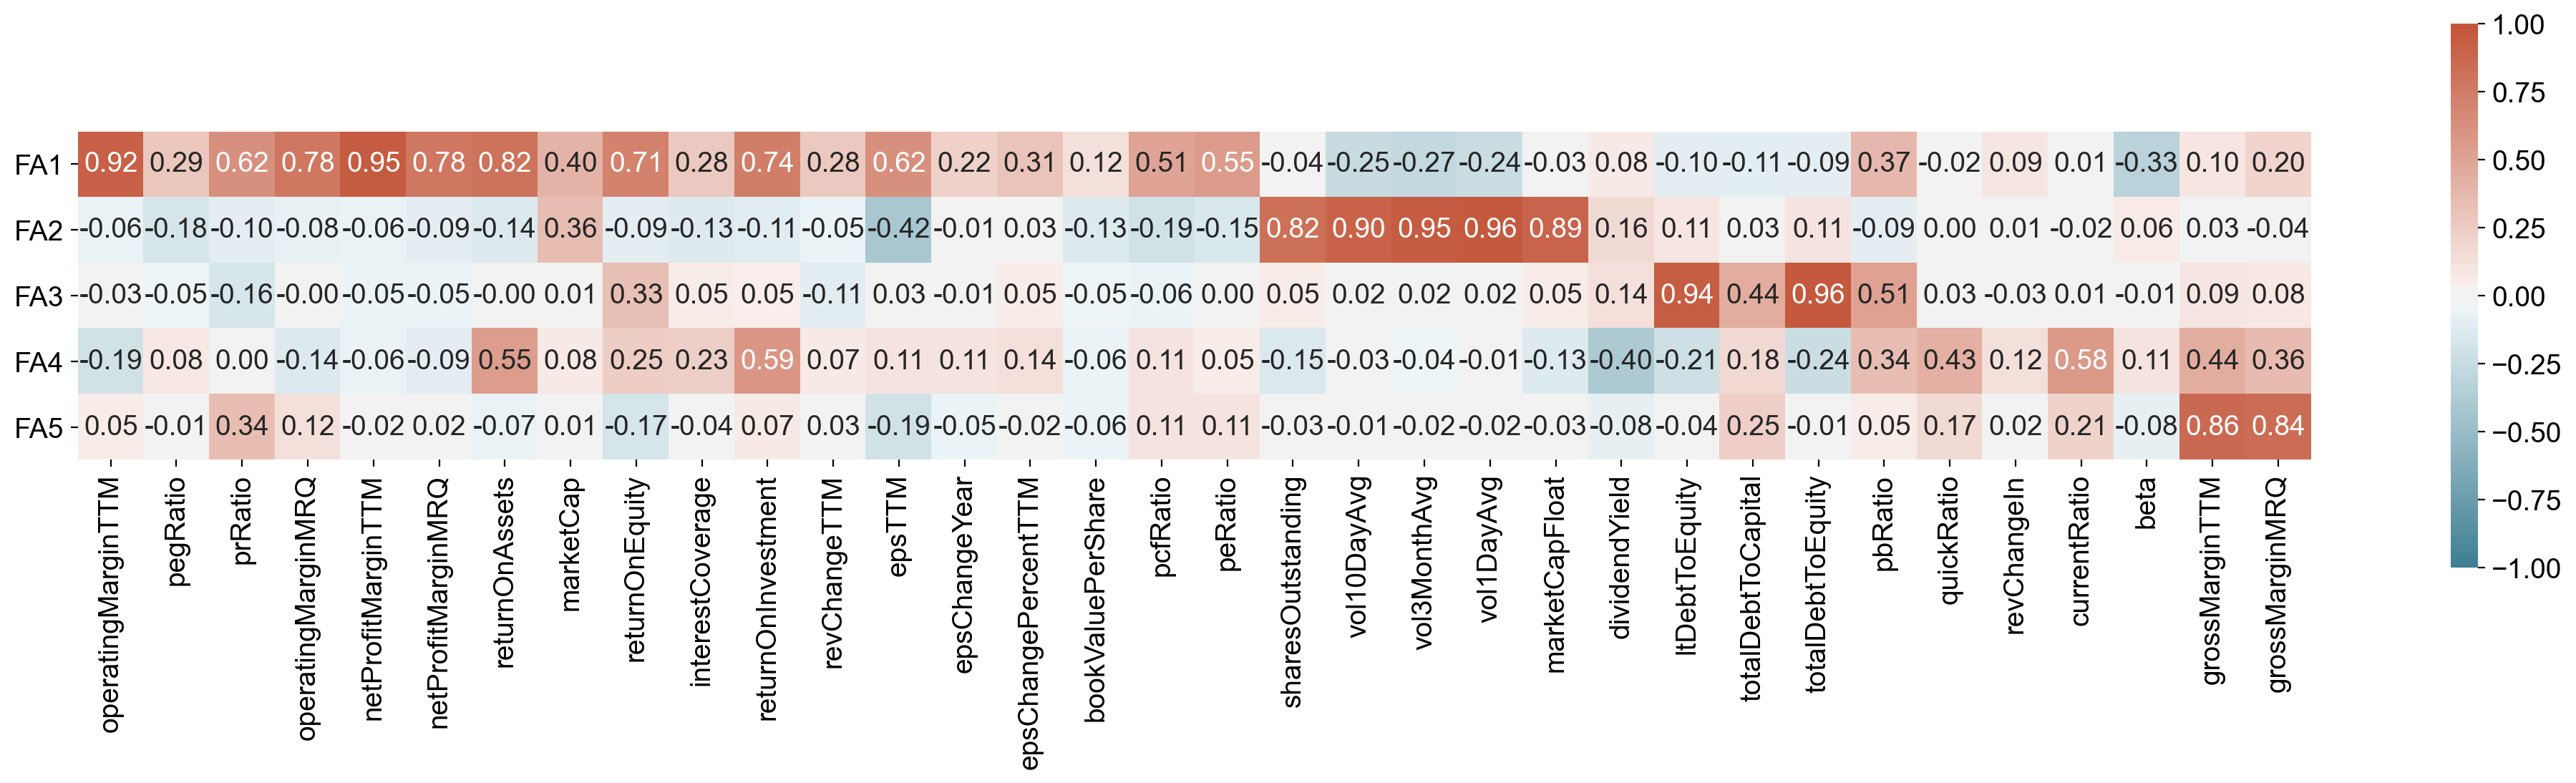

In [182]:
import seaborn as sns

plt.figure(figsize=(25,5))

# plot the heatmap for correlation matrix
ax = sns.heatmap(fa_loading_matrix.drop('Highest_loading', axis=1).T, 
                vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(220, 20, n=200),
                square=True, annot=True, fmt='.2f')

ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0);

As a rule of thumb, only variables with loading of 0.32 and above are interpreted. The greater the loading, the more the vrialbe is a pure measure of the factor. Comrey and Lee (1992) suggest that loadings of:-  

\>71% (50% overlapping variance) are considered excellent;  
\>63% (40% overlapping variance) very good;  
\>55% (30% overlapping variance) good;  
\>45% (20% overlapping variance) fair;  
0.32% (10% overlapping variance) poor;

## In summary, based on the heatmap above: 
- the Factor 1 (FA1) seems to suggest operational/return performance or valuations of a company; 
- FA2 is more correlated to volalities of company share values/market capitals; 
- FA3 seems to suggest long term debt obligations; 
- FA4 seems to suggest short-term debt obligation (i.e. quick/current ratio); and lastly 
- FA5 seems to be correlated with gross margin performance of a company.

# References:  
1. Loadings vs eigenvectors in PCA: when to use one or another? https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another
2. Making sense of principal component analysis, eigenvectors & eigenvalues
 https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/35653#35653
3. Tabachnick & Fidell. Using Multivariate Statistics, Sixth Edition. PEARSON 2013; ISBN-13:9780205956227.